https://nbviewer.jupyter.org/github/plusk01/nonlinearquad/blob/master/utils.ipynb

In [2]:
import numpy as np

# Derivative Filter

Low pass filter with cutoff frequency $\omega_c$.
\begin{align}
H_{LPF}(s) = \frac{\omega_c}{s+\omega_c} = \frac{1}{s/\omega_c+1}
\end{align}

High pass filter with cutoff frequency $\omega_c$.
\begin{align}
H_{HPF}(s) = \frac{s}{s+\omega_c} = \frac{s/\omega_c}{s/\omega_c+1}
\end{align}
$$\tau = RC = \frac{1}{2\pi f_c} = \frac{1}{\omega_c}$$
* For computer, it must be discretized, to map $G(s)$ to $z$-domain, via the bilinear transform
\begin{align}
s \rightarrow \frac{2}{T}\frac{1-z^{-1}}{1+z^{-1}}
\end{align}
$z$ transform can be used to give a discrete-time implementation of the dirty derivate.

In [3]:
# dirty derivative
class DirtyDerivative:
    def __init__(self, order=1, tau=0.5):
        self.tau = tau # higher increase the smoothing
        self.order = order # we use this parameter to know how many measurments to ignore 
                           # so that the incoming data is smooth and stable
        self.x_d1 = None
        self.dxdt = None # current value of derivative
        
    def update(self, x, Ts):
        if self.order > 0:
            self.order -= 1
            self.x_d1 = x
            return np.zeros(x.shape)
        
        # calculate the digital derivative constants
        a1 = (2*self.tau-Ts)/(2*self.tau+Ts)
        a2 = 2/(2*self.tau+Ts)
        
        if self.dxdt is None:
            self.dxdt = np.zeros(x.shape)
            
        # calculate dirivative
        self.dxdt = a1*self.dxdt + a2*(x-self.x_d1)
        
        # store value for next time
        self.x_d1 = x
        
        return self.dxdt

$\Uparrow$ dirty derivative provides a first order derivative of a signal.  
a filtered derivative based on a band-limited low pass transfer function $$G(s) = \frac{s}{\tau * s +1}$$  
Because a pure differentiator ($D(s) = s$) is not realizable.

# Rotation matrices
**Right hand, passive, intrinsic 3-2-1 (Z-Y-X)**  
A yaw ($\psi$) rotation is first performed in $\mathcal{F}_A$ arround the $\mathbf{k}^A$ axis to get to $\mathcal{F}_B$.  
Then, a pitch($\theta$) rotation is performed about the $\mathbf{j}^B$ axis to get to $\mathcal{F}_C$.  
Lastly, a roll ($\phi$) rotation is performed about the $\mathbf{i}^c$ axis to get to $\mathcal{F}_D$.  
The rotations are composed as 
\begin{align}
x^D &= R_C^D(\phi)R^C_B(\theta)R^B_A(\psi)x^A\\
    &= R^D_A(\phi,\theta,\psi)x^A\\
    &= R^D_Ax^A
\end{align}

In [4]:
# input angle in radians
def rotx(ph): 
    return np.array([[1,0,0],[0,np.cos(ph),np.sin(ph)],[0,-np.sin(ph),np.cos(ph)]])
def roty(th): 
    return np.array([[np.cos(th),0,-np.sin(th)],[0,1,0],[np.sin(th),0,np.cos(th)]])
def rotz(ps): 
    return np.array([[np.cos(ps),np.sin(ps),0],[-np.sin(ps),np.cos(ps),0],[0,0,1]])
def rot3(ph,th,ps): 
    return rotx(ph).dot(roty(th).dot(rotz(ps)))
# input angle in degrees
def rotxd(ph): 
    return rotx(np.radians(ph))
def rotyd(th): 
    return roty(np.radians(th))
def rotzd(ps): 
    return rotz(np.radians(ps))
def rot3d(ph,th,ps): 
    return rot3(np.radians(ph),np.radians(th),np.radians(ps))

# Simple PID Controller
In order to implement a PID controller on a computer, we need to discretize our continuous expression for the integral and derivative terms of the PID controller.

In [5]:
class SimplePID:
    def __init__(self, kp, ki, kd, min, max, tau=0.05):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.min = min
        self.max = max
        self.tau = tau

        self.derivative = 0.0
        self.integral = 0.0

        self.last_error = 0.0
        
    @staticmethod
    def _clamp(v,limit):
        return v if np.abs(v)<limit else limit*np.sign(v)
    def run(self, error, dt, derivative=None, pclamp=None):
        # P term
        if self.kp:
            # proportional error clamp , it specified
            e = error if pclamp is None else self._clamp(clamp, pclamp)
            p_term = self.kp*e
        else:
            p_term = 0.0
            
        # D term
        if self.kd:
            if derivative:
                self.derivative = derivative
            elif dt > 0.0001:
                self.derivative = (2.0*self.tau - dt)/(2.0*self.tau + dt)*self.derivative + 2.0/(2.0*self.tau + dt)*(error - self.last_error)
            else:
                self.derivative = 0.0
            d_term = self.kd * self.derivative
        else:
            d_term = 0.0
            
        # I term
        if self.ki:
            self.integral += (dt/2.0) * (error + self.last_error)
            i_term = self.ki * self.integral
        else:
            i_term = 0.0

        # combine
        u = p_term + d_term + i_term
        
        # saturate
        if u < self.min:
            u_sat = self.min
        elif u > self.max:
            u_sat = self.max
        else:
            u_sat = u
            
        # integrator anti-windup
        if self.ki:
            if abs(p_term + d_term) > abs(u_sat):
                # PD is already saturating, so set integrator to 0 but don't let it run backwards
                self.integral = 0
            else:
                # otherwise only let integral term at most take us just up to saturation
                self.integral = (u_sat - p_term - d_term) / self.ki

        # book keeping
        self.last_error = error

        return u_sat

\begin{align}
&u = P+I+D\\
\begin{cases}
P &= kp\cdot e\\
D &= kd\cdot(\frac{2\tau-dt}{2\tau+dt}\frac{de}{dt}+\frac{2}{2\tau+dt}(e-e_{last}))\\
I &= ki\cdot\sum\frac{dt}{2}(e+e_{last})
\end{cases}
\end{align}

# Euler Method
\begin{align}
&\frac{df}{dt} =
\lim_{h\rightarrow 0}
\frac{f(t+h)-f(t)}{h},\ \ g(t) \doteq\frac{df}{dt}(t)
\\
\Rightarrow
& f(t+h)=f(t)+g(t)h
\\
\Rightarrow
& f(K+1)=f(k)+g(k)T_s
\end{align}
* First order, approximation of the differential euqation.
# RK4
\begin{align}
\dot y &= f(t,y)\\
y_{n+1} &= y_n + {h\over6} (k_1+k_2+k_3+k_4)\\
t_{n+1} &= t_n+h\\
\text{where}\ \ \
k_1 &= f(t_n, y_n)\\
k_2 &= f(t_n+{h\over2}, y_n+{h\over2}k_1)\\
k_3 &= f(t_n+{h\over2}, y_n+{h\over2}k_2)\\
k_4 &= f(t_n+h, y_n+hk_3)
\end{align}

In [6]:
def rk4(f, y, dt):
    """Runge-Kutta 4th Order
    
    Solves an autonomous (time-invariant) differential equation of the form dy/dt = f(y).
    """
    k1 = f(y)
    k2 = f(y + dt/2*k1)
    k3 = f(y + dt/2*k2)
    k4 = f(y + dt  *k3)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

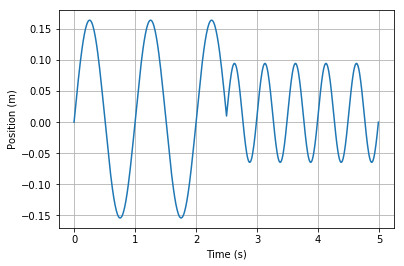

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Tf = 5
Ts = 0.01
N = int(Tf/Ts)

# initital condition
x = 0

# simulation history
x_hist = np.zeros((N,1))

for i in range(N-1):
    # dynamics
    freq = 1 if i < N//2 else 2
    v = np.cos(2*np.pi*freq*(Ts*i))
    f = lambda x: v

    # propagate dynamics by solving the differential equation
    x = rk4(f, x, Ts)
    
    # add to history
    x_hist[i+1] = x
    
plt.plot(np.arange(0, Tf, Ts), x_hist)
plt.grid(); plt.xlabel('Time (s)'); plt.ylabel('Position (m)')
plt.show()